In [133]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch
import pickle

In [134]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

# set default datatype
torch.set_default_dtype(torch.float32)

Training on GPU!


In [135]:
corpus_size = 2000

In [136]:
# data prep - cleaning out unwanted characters and such

import re

def filter_reuters(txt):
    idx = txt.index('-')
    return txt[idx+1:].strip()

def filter_quotation(txt):
    txt = re.sub('"|“|”|’|‘', "", txt)
    return txt

number_match = re.compile('\b.*[0-9].*\b')
punctuation_match = re.compile('\b.*(\.|\\|\/|,\/|\(|\)).*\b')

# test_string = '"dette er bare en "test-streng"'
# filter_quotation(test_string)

In [137]:
# load data and performing additional cleaning
train_df = pd.read_csv('./data/True.csv')
articles = train_df['text'].values.tolist()[0:corpus_size]
for article in articles:
    article = filter_reuters(article)
    article = filter_quotation(article)
    article = number_match.sub(repl="", string=article)
    article = punctuation_match.sub(repl="", string=article)


# articles = [filter_reuters(article) for article in articles]
# articles = [filter_quotation(article) for article in articles]
articles[:5]


['The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a fiscal conservative on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS Face the Nation, drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense discretionary spending on programs that support education, scientific research, inf

In [138]:

def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(articles)
# text = [item for sublist in articles[:5].values for item in sublist]
len(text.split())

760564

In [139]:
# data prep original cleaning - this wasn't enough
# should be merged with the other cleaning cell
# this one removes english stop words and punctuation

stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()

In [140]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['the', 'head'], 'conservative'), (['head', 'conservative'], 'republican'), (['conservative', 'republican'], 'faction')]


In [141]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}


In [142]:
# load word 2 vector dictionary
word_to_vector = {}
vector_to_word = {}

with open('./models/w2v.dat', 'rb') as f_path:
    word_to_vector = pickle.load(f_path)
    

with open('./models/v2w.dat', 'rb') as f_path:
    vector_to_word = pickle.load(f_path)
    
# x,y = word_to_vector['trump']
# trump = vector_to_word[(x,y)]
# print(trump)

In [143]:
inp=[]
tar=[]
key_errors = []
for context, target in trigrams:
    try:
        context_idxs = torch.tensor([word_to_vector[word] for word in context]).type(torch.FloatTensor)
    except KeyError as e:
        key_errors.append(e)
    inp.append(context_idxs)
    try:
        targ = torch.tensor([word_to_vector[target]]).type(torch.FloatTensor)
    except KeyError as e:
        pass
    tar.append(targ)
print(f'{len(key_errors)} key errors')
print(key_errors)

28453 key errors
[KeyError('pas'), KeyError('pas'), KeyError('thats'), KeyError('thats'), KeyError('dont'), KeyError('dont'), KeyError('debtfinanced'), KeyError('debtfinanced'), KeyError('weve'), KeyError('weve'), KeyError('ryans'), KeyError('ryans'), KeyError('discus'), KeyError('discus'), KeyError('dods'), KeyError('dods'), KeyError('currentlyserving'), KeyError('currentlyserving'), KeyError('conservativemajority'), KeyError('conservativemajority'), KeyError('im'), KeyError('im'), KeyError('obamas'), KeyError('obamas'), KeyError('cannot'), KeyError('cannot'), KeyError('undergarment'), KeyError('undergarment'), KeyError('genderbased'), KeyError('genderbased'), KeyError('obamaera'), KeyError('obamaera'), KeyError('serf'), KeyError('serf'), KeyError('cbss'), KeyError('cbss'), KeyError('muellers'), KeyError('muellers'), KeyError('russias'), KeyError('russias'), KeyError('fbis'), KeyError('fbis'), KeyError('muellers'), KeyError('muellers'), KeyError('u'), KeyError('u'), KeyError('fbis'), 

In [144]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [145]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [146]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [149]:
n_epochs = 10
print_every = 10
plot_every = 1
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers).type(torch.FloatTensor).to('cuda')
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

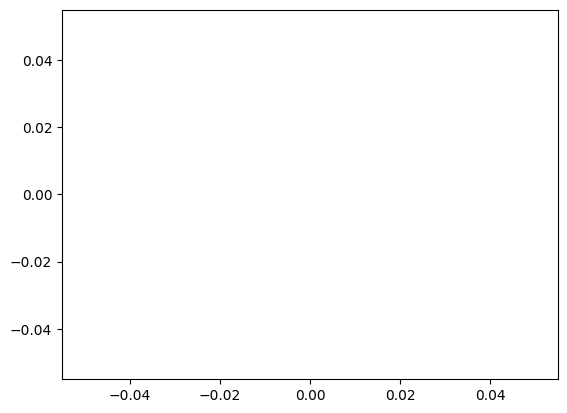

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [ ]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [ ]:
print(evaluate('trump died of', 40, temperature=1))

trump died of schools” 15 conviction part flattening government statement number daca called gas public all earnings approved year trump package four still year reuters official cap deduction mortgage interest 750000 home loan value after dec 31 2025 poll directly attributed trump’s low
